## Environment Setting
Google drive mount (for Colab users) and package importing.
You can optionally install and import torchensemble package for ensemble learning

In [1]:
# For Colab users
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# For import .py file
# you can copy path using right click - path copy
import sys
# sys.path.insert(0,'/content/drive/Mydrive/final_proj_colab')
sys.path.insert(0,'/content/drive/MyDrive/final_proj_colab/easy')

Mounted at /content/drive


In [2]:
import os
import numpy as np
import torch
import torch.nn as nn
import random  
import torchvision.transforms as transforms
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader

## (Optional) Sample Visualization
You can see actual sample images and sorted class indices. Additional matplotlib package is needed.

In [3]:
# Just for reference: see actual samples
import matplotlib.pyplot as plt

alphabet = {
        'A(a)' : '0', 'B(b)' : '1', 'C(c)' : '2', 'D(d)' : '3', 'E(e)' : '4', 'F(f)' : '5', 
        'G(g)' : '6', 'H(h)' : '7', 'I(i)' : '8', 'J(j)' : '9', 'K(k)' : '10','L(l)' : '11', 
        'M(m)' : '12', 'N(n)' : '13', 'O(o)' : '14', 'P(p)' : '15', 'Q(q)' : '16', 'R(r)' : '17', 
        'S(s)' : '18', 'T(t)' : '19', 'U(u)' : '20', 'V(v)' : '21', 'W(w)' : '22', 'X(x)' : '23', 
        'Y(y)' : '24', 'Z(z)' : '25'
    }

(5, 28, 28)


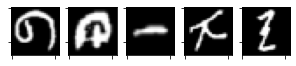

progress label:  4 6 8 10 12 14 
( E(e) G(g) I(i) K(k) M(m) O(o) )


In [4]:
# Just for reference: see actual samples

#load_sample = np.load('./data/emnist_progress_easy_data/sample_data.npy', allow_pickle=True).item()
load_sample = np.load('/content/drive/MyDrive/final_proj_colab/emnist_progress_easy_data/sample_data.npy', allow_pickle=True).item()
sample_data, sample_label = load_sample['train_data'], load_sample['train_label']
print(sample_data.shape)

plt.figure(figsize=(len(sample_data),len(sample_data)))
for i in range(len(sample_data)):
    plt.subplot(1, len(sample_data), i+1)
    ax = plt.gca()
    ax.axes.xaxis.set_ticklabels([])
    ax.axes.yaxis.set_ticklabels([])
    plt.imshow(sample_data[i], cmap='gray')
    
plt.show()
print("progress label: ", end=' ')
label_str = '('

for i in range(len(sample_label)):
    print(int(sample_label[i]), end=' ')
    label_str += " " + list(alphabet.keys())[int(sample_label[i])]
label_str += " )"
print()
print(label_str)

In [5]:
# Use 0th GPU for training
torch.cuda.set_device(0)

In [6]:
# fix random seed to increase reproducibility
# NOTE: Do not modify here!

random_seed = 7
torch.manual_seed(random_seed)
os.environ['PYTHONHASHSEED'] = str(random_seed)
np.random.seed(random_seed)
random.seed(random_seed)
torch.cuda.manual_seed(random_seed)

torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True
%env CUBLAS_WORKSPACE_CONFIG=:16:8

def seed_worker(worker_seed):
    np.random.seed(worker_seed)
    random.seed(worker_seed)
    
# you can modify this
num_workers = 1

env: CUBLAS_WORKSPACE_CONFIG=:16:8


In [7]:
# NOTE: you can modify mean and std for normalization
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)),
])

batch_size = 100

In [8]:
# NOTE: modify path for your setting
from data_utils import Mydataset, collate_fn
# train_path = './data/emnist_progress_easy_data/train'
# valid_path = './data/emnist_progress_easy_data/valid'
train_path = '/content/drive/MyDrive/final_proj_colab/emnist_progress_easy_data/train'
valid_path = '/content/drive/MyDrive/final_proj_colab/emnist_progress_easy_data/valid'
print(os.getcwd())
train_ds = Mydataset(train_path, transform=transform, train=True)
valid_ds = Mydataset(valid_path, transform=transform, train=False)

train_dl = DataLoader(train_ds, batch_size=batch_size, collate_fn=collate_fn, shuffle=True)
valid_dl= DataLoader(valid_ds, batch_size=batch_size, collate_fn=collate_fn, shuffle=False)

/content
0 load from 0 to 5000
1 load from 5000 to 10000
2 load from 10000 to 15000
3 load from 15000 to 20000
4 load from 20000 to 25000
5 load from 25000 to 30000
6 load from 30000 to 35000
7 load from 35000 to 40000
8 load from 40000 to 45000
9 load from 45000 to 50000
0 load from 0 to 5000
1 load from 5000 to 10000


In [14]:
import time

def train(model, model_optim, loss_func, max_epoch, train_dl, valid_dl, 
          load_path=None, save_path='./drive/MyDrive/final_proj_colab/easy/model_easy.pt'):
    ##############################################################################
    #                          IMPLEMENT YOUR CODE                               #
    ##############################################################################
    # Load your states
    
    loaded_epoch = 0
    loaded_loss1_list = None
    loaded_loss2_list = None
    loaded_loss_list = None
    loaded_gru1_acc_list = None
    loaded_gru2_acc_list = None
    loaded_train_acc_list = None
    loaded_valid_acc_list = None

    if load_path is not None:
        state = torch.load(load_path)
        model.load_state_dict(state["model"])
        model_optim.load_state_dict(state["optimizer"])
        loaded_epoch = state["epoch"]
        loaded_loss1_list = state["loss1_list"]
        loaded_loss2_list = state["loss2_list"]
        loaded_loss_list = state["loss_list"]
        loaded_gru1_acc_list = state["gru1_acc_list"]
        loaded_gru2_acc_list = state["gru2_acc_list"]
        loaded_train_acc_list = state["train_acc_list"]
        loaded_valid_acc_list = state["valid_acc_list"]
        # ...
    start_time = time.time()
        
    ##############################################################################
    #                          END OF YOUR CODE                                  #
    ##############################################################################
    
    loss1_list = [] if loaded_loss1_list == None else loaded_loss1_list
    loss2_list = [] if loaded_loss2_list == None else loaded_loss2_list
    loss_list = [] if loaded_loss_list == None else loaded_loss_list
    gru1_acc_list = [] if loaded_gru1_acc_list == None else loaded_gru1_acc_list
    gru2_acc_list = [] if loaded_gru2_acc_list == None else loaded_gru2_acc_list
    train_acc_list = [] if loaded_train_acc_list == None else loaded_train_acc_list
    valid_acc_list = [] if loaded_valid_acc_list == None else loaded_valid_acc_list

    for epoch in np.array(list(range(max_epoch - loaded_epoch))) + loaded_epoch:
        for step, sample in enumerate(train_dl):
            model.train()
            img, label = sample
            outputs = model((img, label))
            
            ##############################################################################
            #                          IMPLEMENT YOUR CODE                               #
            ##############################################################################
            # Problem 4: implement optimization part             
            if torch.cuda.is_available():
              device = 'cuda'
            else:
              device = 'cpu'

            y1 = torch.zeros(len(label), len(label[0])-1, 26).to(device)
            y2 = torch.zeros(len(label), len(label[0])-1, 26).to(device)
            for i in range(0, len(label)):
              for j in range(0, len(label[0])):
                if j != len(label[0])-1:
                  y1[i][j] = nn.functional.one_hot(torch.LongTensor(label[i][j]), num_classes = 26)  
                  # one_hot = nn.functional.one_hot(torch.LongTensor(label[i][j]), num_classes = 26)  
                  # soft_label = one_hot * (1 - 0.1) + (0.1 / 26)
                  # y1[i][j] = soft_label
                if j != 0:
                  # y2[i][j-1] = nn.functional.one_hot(torch.LongTensor(label[i][j]), num_classes = 26)
                  one_hot = nn.functional.one_hot(torch.LongTensor(label[i][j]), num_classes = 26)  
                  soft_label = one_hot * (1 - 0.1) + (0.1 / 26)
                  y2[i][j-1] = soft_label
            
            output1, output2 = outputs
            loss1 = loss_func(output1, y1)
            loss2 = loss_func(output2, y2)
            
            loss = (loss1 + loss2) / 2


            model_optim.zero_grad()
            loss.backward()
            model_optim.step()
      
            
            ##############################################################################
            #                          END OF YOUR CODE                                  #
            ##############################################################################
            
            # you can modify below train evaluation code
            
            if (step + 1) % print_interval == 0:
                n_samples1 = 0
                n_samples2 = 0
                n_samples3 = 0

                n_correct1 = 0
                n_correct2 = 0
                n_correct3 = 0
                n_correct4 = 0

                for i in range(batch_size):
                  n_samples1 += len(label[i])
                  n_correct1 += (output1[i].argmax(-1) == label[i][0:-1].cuda()).sum().item()            
                  n_correct2 += (output2[i].argmax(-1) == label[i][1:].cuda()).sum().item()            

                n_samples2 += batch_size
                for i in range(batch_size):
                  n_correct3 += (output2[i][-1].argmax() == label[i][-1].cuda()).item()

                model.eval()
                for _, sample in enumerate(valid_dl):
                  img, label = sample            
                  outputs = model(img)
                  n_samples3 += batch_size
                  for i in range(batch_size):
                      n_correct4 += (outputs[i].argmax() == label[i][-1].cuda()).item()

                loss1_list.append(loss1.item())
                loss2_list.append(loss2.item())
                loss_list.append(loss.item())                
                gru1_acc_list.append(100 * (n_correct1 / n_samples1))
                gru2_acc_list.append(100 * (n_correct2 / n_samples1))
                train_acc_list.append(100 * (n_correct3 / n_samples2))
                valid_acc_list.append(100 * (n_correct4 / n_samples3))

                print('epoch:', epoch + 1, 'step:', step + 1, 'loss1:', loss1.item(), 'loss2:', loss2.item(), 'loss:', loss.item())
                print('cnn-gru1 accuracy:', 100 * (n_correct1 / n_samples1), 'gru2 accuracy', 100 * (n_correct2 / n_samples1), 'training accuracy', 100 * (n_correct3 / n_samples2), 'validation accuracy', 100 * (n_correct4 / n_samples3))
                elapsed_time = time.time() - start_time
                print('elapsed time : %d h %d m %d s' % (elapsed_time / 3600, (elapsed_time % 3600) / 60, (elapsed_time % 60)))            
                """
                #
                for b in range(batch_size):
                  sample_data = []
                  for iter in range(len(img[b])):
                    sample_data.append(img[b][iter][0])
                  sample_label = label[b]
                  plt.figure(figsize=(len(sample_data),len(sample_data)))
                  for i in range(len(sample_data)):
                      plt.subplot(1, len(sample_data), i+1)
                      ax = plt.gca()
                      ax.axes.xaxis.set_ticklabels([])
                      ax.axes.yaxis.set_ticklabels([])
                      plt.imshow(sample_data[i], cmap='gray')
                      
                  plt.show()
                  print("progress label: ", end=' ')
                  label_str = '('

                  for i in range(len(sample_label)):
                      print(int(sample_label[i]), end=' ')
                      label_str += " " + list(alphabet.keys())[int(sample_label[i])]
                  label_str += " )"
                  print()
                  print(label_str)
                  print(output2[b].argmax(-1))
                #
                """
                
        # you can modify evaluation code

        with torch.no_grad():
                ##############################################################################
                #                          IMPLEMENT YOUR CODE                               #
                ##############################################################################
                # Save your states (optional)
                state = {
                    "model": model.state_dict(),
                    "optimizer": model_optim.state_dict(),
                    "epoch": epoch + 1,                                
                    "loss1_list": loss1_list,
                    "loss2_list": loss2_list,
                    "loss_list": loss_list,
                    "gru1_acc_list": gru1_acc_list,
                    "gru2_acc_list": gru2_acc_list,
                    "train_acc_list": train_acc_list,
                    "valid_acc_list": valid_acc_list
                    # ...
                }
                ##############################################################################
                #                          END OF YOUR CODE                                  #
                ##############################################################################
                torch.save(state, save_path)

# you can modify evaluation code

def eval(valid_dl, load_path):
    state = torch.load(load_path)
    model.load_state_dict(state["model"])
    ##############################################################################
    #                          IMPLEMENT YOUR CODE                               #
    ##############################################################################
    # Problem 5: implement evaluation part
    # you can simply copy or modify above evaluation code in train function

    n_samples = 0
    n_correct = 0

    for step, sample in enumerate(valid_dl):
        img, label = sample
        outputs = model(img)
        """
        #
        for b in range(batch_size):
          sample_data = []
          for iter in range(len(img[b])):
            sample_data.append(img[b][iter][0])
          sample_label = label[b]
          plt.figure(figsize=(len(sample_data),len(sample_data)))
          for i in range(len(sample_data)):
              plt.subplot(1, len(sample_data), i+1)
              ax = plt.gca()
              ax.axes.xaxis.set_ticklabels([])
              ax.axes.yaxis.set_ticklabels([])
              plt.imshow(sample_data[i], cmap='gray')
              
          plt.show()
          print("progress label: ", end=' ')
          label_str = '('

          for i in range(len(sample_label)):
              print(int(sample_label[i]), end=' ')
              label_str += " " + list(alphabet.keys())[int(sample_label[i])]
          label_str += " )"
          print()
          print(label_str)
        #
        """


        n_samples += batch_size
        for i in range(batch_size):
            n_correct += (outputs[i].argmax() == label[i][len(label[i])-1].cuda()).item()

        
            
    ##############################################################################
    #                          END OF YOUR CODE                                  #
    ##############################################################################
        
    valid_accuracy = 100 * (n_correct / n_samples)
    print('Valid accuracy: %.2f' % (valid_accuracy))

In [15]:
# You can add or modify your ConvLSTM's hyperparameter (keys and values)
kwargs = {
    'cnn_input_dim': 1,
    'cnn_hidden_size': 64,
    'rnn_input_dim': 32,
    'rnn_hidden_size': 64,
    'rnn_num_layers': 2,
    'rnn_dropout': 0.0
}

NUM_CLASSES = 26
SEQUENCE_LENGTH = 5

In [16]:
# for reload .py file without restart
import importlib
import models_easy
importlib.reload(models_easy)

from models_easy import ConvGRU

model = ConvGRU(sequence_length=SEQUENCE_LENGTH, num_classes=NUM_CLASSES, **kwargs).cuda()
print(model)
##############################################################################
#                          IMPLEMENT YOUR CODE                               #
##############################################################################

model_optim = torch.optim.Adam(model.parameters(), lr=0.0005)
# loss_func = nn.CrossEntropyLoss()
loss_func = nn.MSELoss()

##############################################################################
#                          END OF YOUR CODE                                  #
##############################################################################

ConvGRU(
  (conv): CustomCNN(
    (layer1): Sequential(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (layer2): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (layer3): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (layer4): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (layer5): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (

In [17]:
# NOTE: you can modify hyperparameters

print_interval = 50
max_epoch = 2

In [18]:
# load_path = './drive/MyDrive/final_proj_colab/easy/model_easy.pt'
load_path = None
train(model, model_optim, loss_func, max_epoch, train_dl, valid_dl, load_path=load_path, save_path='./drive/MyDrive/final_proj_colab/easy/model_easy.pt')

epoch: 1 step: 50 loss1: 0.018002906814217567 loss2: 0.028804760426282883 loss: 0.0234038345515728
cnn-gru1 accuracy: 67.0 gru2 accuracy 23.5 training accuracy 30.0 validation accuracy 25.430000000000003
elapsed time : 0 h 0 m 23 s
epoch: 1 step: 100 loss1: 0.004872945602983236 loss2: 0.020144417881965637 loss: 0.01250868197530508
cnn-gru1 accuracy: 76.83333333333333 gru2 accuracy 53.0 training accuracy 40.0 validation accuracy 39.21
elapsed time : 0 h 0 m 46 s
epoch: 1 step: 150 loss1: 0.0020820251666009426 loss2: 0.011131221428513527 loss: 0.006606623530387878
cnn-gru1 accuracy: 81.16666666666667 gru2 accuracy 67.16666666666666 training accuracy 44.0 validation accuracy 58.230000000000004
elapsed time : 0 h 1 m 10 s
epoch: 1 step: 200 loss1: 0.0013341213343665004 loss2: 0.003834232222288847 loss: 0.0025841768365353346
cnn-gru1 accuracy: 82.0 gru2 accuracy 81.66666666666667 training accuracy 96.0 validation accuracy 89.2
elapsed time : 0 h 1 m 32 s
epoch: 1 step: 250 loss1: 0.00061118

In [19]:
# load and evaluate model
load_path = './drive/MyDrive/final_proj_colab/easy/model_easy.pt'
eval(valid_dl, load_path)

Valid accuracy: 99.75


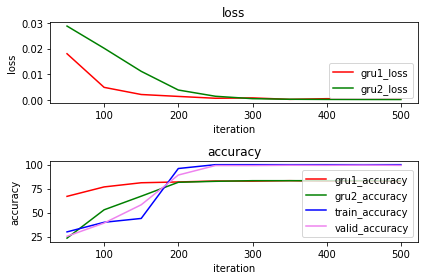

In [20]:
load_path = './drive/MyDrive/final_proj_colab/easy/model_easy.pt'
state = torch.load(load_path)

loss1_list = state["loss1_list"]
loss2_list = state["loss2_list"]
loss_list = state["loss_list"]
gru1_acc_list = state["gru1_acc_list"]
gru2_acc_list = state["gru2_acc_list"]
train_acc_list = state["train_acc_list"]
valid_acc_list = state["valid_acc_list"]

import matplotlib.pyplot as plt

x = []
for i in range(len(loss1_list)):
  x.append(50 * (i+1))

max = 10

plt.subplot(2, 1, 1)
plt.title('loss')
plt.plot(x[:max], loss1_list[:max], 'r', label='gru1_loss')
plt.plot(x[:max], loss2_list[:max], 'g', label='gru2_loss')
plt.xlabel('iteration')
plt.ylabel('loss')
plt.legend(loc='lower right')

plt.subplot(2, 1, 2)
plt.title('accuracy')
plt.plot(x[:max], gru1_acc_list[:max], 'r', label='gru1_accuracy')
plt.plot(x[:max], gru2_acc_list[:max], 'g', label='gru2_accuracy')
plt.plot(x[:max], train_acc_list[:max], 'b', label='train_accuracy')
plt.plot(x[:max], valid_acc_list[:max], 'violet', label='valid_accuracy')
plt.xlabel('iteration')
plt.ylabel('accuracy')
plt.legend(loc='lower right')

plt.tight_layout()
plt.show()


### Test code for grading by TA

In [ ]:
# you do not need to modify here
from data_utils import Mydataset, collate_fn

test_path = './data/emnist_progress_easy_data/test'
test_ds = Mydataset(test_path, transform=transform, train=False)
test_dl= DataLoader(test_ds, batch_size=batch_size, collate_fn=collate_fn, shuffle=False)

In [ ]:
# please change the model name to your submission model name
load_path = './model_easy.pt'
eval(test_dl, load_path)